In [72]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [73]:
%cd /content/gdrive/My Drive/635project/
%ls

/content/gdrive/.shortcut-targets-by-id/1Me9xozqdwVlFbKS8-5OyymO00-PcdX5z/635project
 635_F20_Li_Report.docx
 data/
'Initial Schedules.png'
'Initial Schedules wrong.png'
'Modified Schedules wrong.png'
'Multi-mode resource-constrained project scheduling usingmodified variable neighborhood search heuristic.pdf'
 MVNSH_MRCPSPs.ipynb
 __pycache__/


In [74]:
path = "/content/gdrive/My Drive/635project/"

In [6]:
import re
import time
import math
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pdb

# PSPLIB 
------------------
J10, 12, 14, 16, 18, 20, 30

# Constants

In [2]:
"""
INPUTs
args: 
    M_i
    d_im
    P_prec
    num_r, R_r, U_imr
    num_nr, R_nr, U_imnr: default None
"""
# multi-mode
M_i = [1,2,3]

# renewable and nonrenewable resource type
num_r = [1,2]  # R1, R2
num_nr = None

# renewable and nonrenewable resource availability
# R_r = {0:9, 1:4}
R_r = [9,4]
R_nr = None

# renewable and nonrenewable resource requirement of activity i in mode m, either R1 or R2
U_imr ={1:{1:[0,0],2:[0,0],3:[0,0]},
        2:{1:[6,0],2:[5,0],3:[0,6]},
        3:{1:[0,4],2:[7,0],3:[0,2]},
        4:{1:[7,0],2:[6,0],3:[5,0]},
        5:{1:[0,9],2:[2,0],3:[0,5]},
        6:{1:[4,0],2:[0,8],3:[2,0]},
        7:{1:[5,0],2:[0,7],3:[4,0]},
        8:{1:[6,0],2:[3,0],3:[4,0]},
        9:{1:[4,0],2:[2,0],3:[1,0]},
        10:{1:[4,0],2:[0,2],3:[1,0]},
        11:{1:[0,2],2:[0,1],3:[0,1]},
        12:{1:[0,0],2:[0,0],3:[0,0]},}
U_imnr = None

# duration of activity i in mode m
d_im={1:{1:0,2:0,3:0},
      2:{1:3,2:9,3:10},
      3:{1:1,2:1,3:5},
      4:{1:3,2:5,3:8},
      5:{1:4,2:6,3:10},
      6:{1:2,2:4,3:6},
      7:{1:3,2:6,3:8},
      8:{1:4,2:10,3:9},
      9:{1:2,2:7,3:10},
      10:{1:1,2:1,3:9},
      11:{1:6,2:9,3:9},
      12:{1:0,2:0,3:0},}

# adjacent matrix: precedence relationships
P_prec={1:[2,3,4],
        2:[5,6],
        3:[10,11],
        4:[9],
        5:[7,8],
        6:[11],
        7:[9,10],
        8:[9],
        9:[12],
        10:[12],
        11:[12],}
        # 12:[12]}

numI = 10                        # num of activities
I = [2,3,4,5,6,7,8,9,10,11]      # activities
# i = 1,2,...,11,11+1            # including start and end dummy nodes
A = [1,2,3,4,5,6,7,8,9,10,11,12] # the set of nodes


"""Parameters"""
# sBest = 
fBest = 15   # 1-2-5-8-9-12 = 3+6+4+2 = 15
runMax = 30  # max iterations
tMax = 25    # for plot

# Helper functions

In [3]:
"""helpers"""
# mode selection rule: shortest possible way, if tie, choose smaller order
def mode_selection(dict_dim,dict_Uimr):
    """
    mode selection rule
    SFM: shortest possible way, if d tie, calculate RU; if RU also tie, choose smaller order
    """
    sort_m = sorted(dict_dim.values())

    # d tie, calculate RU
    if sort_m[0] in sort_m[1:]:
        m = 0
        d = 0
        ru = np.sum(R_r)
        for i,di in enumerate(dict_dim.values()):
            if di==sort_m[0]:
                mi = i+1
                rui = np.sum(dict_Uimr[mi])
                if rui<ru:
                    m=mi
                    d=di
                    ru=rui
        return m, d

    else:
        # min_d = sort_m[0]
        for d in sort_m:
            m = list(dict_dim.keys())[list(dict_dim.values()).index(d)]
            if ((np.array(R_r) - np.array(dict_Uimr[m]))>=0).all():
                return m, d


# priority rule: random selection
def priority_rule(SE):
    """priority rule: random selection"""
    return random.choice(SE)

# find type of renewable resource R, either R1 or R2
def typeR(U_im):
    """U_im (list)"""
    r_id = 0
    r = 0
    # print(U_im,type(U_im))
    for i in range(len(U_im)):
        if U_im[i] != 0:
            r_id = i
            r = U_im[i]
    return r_id,r

# union of 2 sets
def uni(s1, s2):
    s = list(set(s1).union(set(s2)))
    return s

# difference of 2 sets
def diff(s1, s2):
    s = list(set(s1) - set(s2))
    return s


"""Pre-process"""
def data_process(A, d_im, U_imr):
    D_i = {}
    U_i = {}
    U_im = {}
    for i in A:
        m_i,d_i = mode_selection(d_im[i], U_imr[i])
        r_im = U_imr[i][m_i]
        r_id, r = typeR(r_im)
        D_i[i] = d_i
        U_i[i] = {r_id: r}
        U_im[i] = r_im
    return D_i, U_i, U_im


def get_pred(prec):
    """
    get all predecessors of activities
    args:
        prec (dict): P_prec constant
    return:
        P_pre (dict)
    """
    P_pre = {}

    for i in prec:
        succ = prec[i]
        for j in succ:
            if j not in P_pre:
                P_pre[j] = [i]
            else:
                P_pre[j].append(i)
    return P_pre

In [ ]:
mode_selection(d_im[10],U_imr[10])

(2, 1)

In [4]:
D_i, U_i, U_im = data_process(A,d_im,U_imr)
# print(D_i)
# print(U_i)
# print(U_im)

In [ ]:
pr = get_pred(P_prec)
pr

{2: [1],
 3: [1],
 4: [1],
 5: [2],
 6: [2],
 7: [5],
 8: [5],
 9: [4, 7, 8],
 10: [3, 7],
 11: [3, 6],
 12: [9, 10, 11]}

# Initial schedules
------------------------
algorithm (a): generate initial schedules

In [5]:
def initial_schedule2(d_im,P_prec,r,R_r,U_imr,nr=None,R_nr=None,U_imnr=None):
    """
    return:
        s (list): start time
        f (list): end time
        order (dict): activity sequence
    """
    
    g, t = 0,0
    C_g = []   # already scheduled and completed
    E_g = []   # predecessors Predj have been completed 
    A_g = [1]  # active 
    SE_g = [1] # a subset of E_g, will start at time t_g
    
    s = np.zeros((len(num_r),len(A)))
    f = np.zeros((len(num_r),len(A)))
    order = {}

    D_i, U_i, U_im = data_process(A,d_im,U_imr)
    Prec_i = get_pred(P_prec)

    # for run in range(runMax):
        
    # while len(uni(C_g, A_g)) <= len(A):
    while len(C_g) <= len(A):

        g += 1
        t += 1

        t_g = tMax
        for i in A_g:
            r_id,_ = typeR(U_im[i])
            t_g = min(t_g, f[r_id][i-1])

        t_g_i = []
        A_g_new = []
        for i in A_g:
            r_id,_ = typeR(U_im[i])
            if f[r_id,i-1]<=t_g:
                t_g_i.append(i)
            else: A_g_new.append(i)
        
        C_g = uni(C_g, t_g_i)
        A_g = A_g_new
        order[g] = t_g_i

        C_g_succ = []
        for i in C_g:
            C_g_succ += P_prec[i]
        C_g_succ = list(set(C_g_succ))

        C_g_succ_new = []
        for i_c in C_g_succ:
            isvalid = True
            for i_c_prec in Prec_i[i_c]:
                if i_c_prec not in C_g and isvalid:
                    isvalid = False
            if isvalid: C_g_succ_new.append(i_c)

        E_g = diff(C_g_succ_new, uni(C_g, A_g))
        SE_g = []

        Rr_g = []
        for i in A_g:
            u_i = U_im[i]
            Rr_g.append(u_i)
        Rr_g = R_r - np.sum(Rr_g,axis=0)
        # Rnr_g = 

        # print("iter: ",g)
        # print("Complete: ",C_g)
        # print("Activate: ",A_g)
        # print("Eligible: ",E_g)
        # print("SubE: ",SE_g)
        # print("\n")

        while E_g:
            i_next = priority_rule(E_g)
            u_i_next = U_im[i_next]
            E_g = diff(E_g, [i_next])

            if ((Rr_g-u_i_next)>=0).all():
                # if Rnr_g- 

                r_id,r = typeR(u_i_next)

                SE_g = uni(SE_g, [i_next])
                A_g = uni(A_g, [i_next])
                Rr_g -= u_i_next
                s[r_id][i_next-1] = t_g
            else:
                SE_g = SE_g
                A_g = A_g

        for i in SE_g:
            r_id,_ = typeR(U_im[i])
            f[r_id][i-1] = s[r_id][i-1] + D_i[i]

        if len(C_g) == len(A)-1:
            # print("end: ",C_g)
            break
    return s,f,order

In [ ]:
# s,f,order = initial_schedule2(d_im,P_prec,num_r,R_r,U_imr)

1 [2, 3, 4]
1 [2, 3, 4]
iter:  1
Complete:  [1]
Activate:  []
Eligible:  [2, 3, 4]
SubE:  []


2 [2, 3, 4, 10, 11]
2 [2, 3, 4]
iter:  2
Complete:  [1, 3]
Activate:  [4]
Eligible:  [2]
SubE:  []


3 [2, 3, 4, 9, 10, 11]
3 [2, 3, 4]
iter:  3
Complete:  [1, 3, 4]
Activate:  []
Eligible:  [2]
SubE:  []


4 [2, 3, 4, 5, 6, 9, 10, 11]
4 [2, 3, 4, 5, 6]
iter:  4
Complete:  [1, 2, 3, 4]
Activate:  []
Eligible:  [5, 6]
SubE:  []


5 [2, 3, 4, 5, 6, 9, 10, 11]
5 [2, 3, 4, 5, 6, 11]
iter:  5
Complete:  [1, 2, 3, 4, 6]
Activate:  [5]
Eligible:  [11]
SubE:  []


6 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
6 [2, 3, 4, 5, 6, 7, 8, 11]
iter:  6
Complete:  [1, 2, 3, 4, 5, 6]
Activate:  [11]
Eligible:  [8, 7]
SubE:  []


7 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
7 [2, 3, 4, 5, 6, 7, 8, 11]
iter:  7
Complete:  [1, 2, 3, 4, 5, 6, 11]
Activate:  [8]
Eligible:  [7]
SubE:  []


8 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
8 [2, 3, 4, 5, 6, 7, 8, 11]
iter:  8
Complete:  [1, 2, 3, 4, 5, 6, 8, 11]
Activate:  []
Eligible:  [7]
Su

In [ ]:
order

{1: [1],
 2: [3],
 3: [4],
 4: [2],
 5: [6],
 6: [5],
 7: [11],
 8: [8],
 9: [7],
 10: [10],
 11: [9]}

here:  1 0.0
1 0 0 0 0
3 0 0 4 1
4 0 0 7 3
2 3 0 6 3
6 6 0 4 2
here:  5 6.0
5 6 4.0 2 6
11 8 0 2 6
8 12 0 6 4
7 16 0 5 3
10 19 0 2 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


9 19 0 4 2


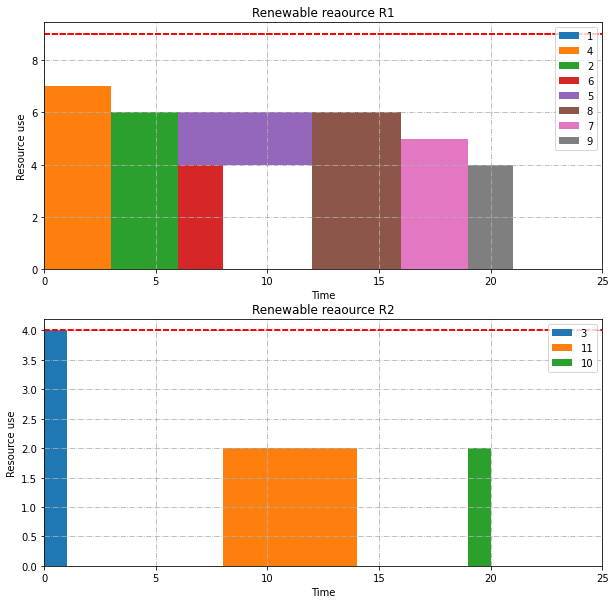

In [ ]:
plottask(s,f,order)

# Neighborhood Structure

## Enhanced move strategy
----------------------------
forward and backward swap/move (this paper)

## Intraroute moves
-----------------------
swap (this paper), 2-opt, 3-opt, insertion

## Interroute moves
-----------------------
exchange(m,n), cross, shift(0,1), replace(1,1)

# Shaking Phase
--------------
algorithm (b): enhanced activity swapping

In [ ]:
ord = {1: [1],
        2: [3],
        3: [4],
        4: [2],
        5: [6],
        6: [5],
        7: [11],
        8: [8],
        9: [7],
        10: [10],
        11: [9]}
# ord = list(ord.values())
ord = [o[0] for o in list(ord.values())]
ord

[1, 3, 4, 2, 6, 5, 11, 8, 7, 10, 9]

In [89]:
"""
extensive experiment: generate several initial schedules and use the best one
"""

runMax = 1000
def generate_init(runMax):
    orders = []
    ord_dic = {}
    for k in range(runMax):
        sk,fk,ok = initial_schedule2(d_im,P_prec,num_r,R_r,U_imr)
        f = max(fk.flatten())
        ord = [o[0] for o in list(ok.values())]
        if ord not in orders:
            orders.append(ord)
            if f not in ord_dic:
                ord_dic[f] = [ord]
            else: ord_dic[f].append(ord)
    return orders,ord_dic

In [90]:
generate_init(1000)

([[1, 3, 4, 2, 6, 5, 11, 8, 7, 10, 9],
  [1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9],
  [1, 3, 4, 2, 6, 5, 11, 7, 10, 8, 9],
  [1, 3, 2, 6, 4, 5, 11, 7, 10, 8, 9],
  [1, 3, 2, 4, 6, 5, 8, 11, 7, 10, 9],
  [1, 3, 2, 6, 4, 5, 11, 8, 7, 10, 9]],
 {18.0: [[1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9],
   [1, 3, 2, 6, 4, 5, 11, 7, 10, 8, 9],
   [1, 3, 2, 4, 6, 5, 8, 11, 7, 10, 9],
   [1, 3, 2, 6, 4, 5, 11, 8, 7, 10, 9]],
  21.0: [[1, 3, 4, 2, 6, 5, 11, 8, 7, 10, 9],
   [1, 3, 4, 2, 6, 5, 11, 7, 10, 8, 9]]})

In [91]:
orders,ord_dic = generate_init(runMax)

BS = min(ord_dic.keys())  # best makespan
BS_unique = ord_dic[BS]   # all feasible unique best schedules

print("Unique schedules: \n", BS_unique)

Unique schedules: 
 [[1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9], [1, 3, 2, 6, 4, 5, 11, 8, 7, 10, 9], [1, 3, 2, 4, 6, 5, 8, 11, 7, 10, 9], [1, 3, 2, 6, 4, 5, 11, 7, 10, 8, 9]]


In [ ]:
P_prec={1:[2,3,4],
        2:[5,6],
        3:[10,11],
        4:[9],
        5:[7,8],
        6:[11],
        7:[9,10],
        8:[9],
        9:[12],
        10:[12],
        11:[12],}
get_pred(P_prec)

{2: [1],
 3: [1],
 4: [1],
 5: [2],
 6: [2],
 7: [5],
 8: [5],
 9: [4, 7, 8],
 10: [3, 7],
 11: [3, 6],
 12: [9, 10, 11]}

In [86]:
def ifswap(id,i,cs):
    """
    Apply precedence and resource constraints
    args:
        id: current activity 
        i:  swap activity
        cs: current schedules
    return:
        ifswap (bool): if id and i can swap
    """
    i_pred = get_pred(P_prec)

    isvalid = False
    if i not in P_prec[id]:
        if set(i_pred[i]) <= set(cs[:id]):  # < if a include b; <= if b is subset of a
            isvalid = True
      
    return isvalid

In [87]:
def check_unique(feas_uni):
    """
    args:
        feas_uni (list): all feasible unique schedules after swapping
    return:
        isunique (bool) 
    """
    isunique = True
    for i,f in enumerate(feas_uni):
        ff = feas_uni[:i]+feas_uni[i+1:]
        if f in ff:
            ii = ff.index(f)
            print(i, ":", f, "same", ii)
            isunique = False
    return isunique

In [88]:
def swap(BS_uni):
    """
    Enhanced activity swapping strategy
    args:
        BS_uni (2d-list): a set of unique feasible schedules with best makespan generated by algorithm (a)
    return:
        AS (2d-list): feasible unique schedules
    """
    AS = []
    cnt = 0
    for p in range(len(BS_uni)):       # p: num of unique best schedules
        CS = BS_uni[p]
        for k in range(1,len(A)-1):    # k: activities available in project, excluding dummy end nodes, start from activity 1
            activity = CS[k]
            print("\n", k,":", activity, BS_uni[p])

            # forward swap
            CS_copy_f = copy.deepcopy(CS)
            for i in range(len(A)-1-k):
                id1 = CS_copy_f.index(activity)
                if ifswap(CS_copy_f[id1],CS_copy_f[k+i],CS_copy_f):   # apply constraints
                    CS_copy_f[id1],CS_copy_f[k+i] = CS_copy_f[k+i],CS_copy_f[id1]
                    print(p,k,i,CS_copy_f)
                    if CS_copy_f not in AS:   # if unique
                        cnt += 1
                        print(cnt, "Forward PICK: ", CS_copy_f)
                        find = copy.deepcopy(CS_copy_f)
                        AS.append(find)

            # backward swap
            CS_copy_b = copy.deepcopy(CS)
            for j in range(k-1):
                id2 = CS_copy_b.index(activity)
                if ifswap(CS_copy_b[k-j-1],CS_copy_b[id2],CS_copy_b):  # apply constraints
                    CS_copy_b[id2],CS_copy_b[k-j-1] = CS_copy_b[k-j-1],CS_copy_b[id2]
                    print(p,k,j,CS_copy_b)
                    if CS_copy_b not in AS:   # if unique
                        cnt += 1
                        print(cnt, "Backward PICK: ", CS_copy_b)
                        find = copy.deepcopy(CS_copy_b)
                        AS.append(find)
    
    if check_unique(AS):
        print("All feasible schedules are uniqe. GOOD LUCK.")
        return AS
    else:
        print("Please double check SWAP algorithm !!! ")

In [22]:
Feas_unique = swap(BS_unique)
Feas_unique


 1 : 3 [1, 3, 2, 4, 6, 5, 8, 11, 7, 10, 9]
0 1 0 [1, 3, 2, 4, 6, 5, 8, 11, 7, 10, 9]
0 1 1 [1, 2, 3, 4, 6, 5, 8, 11, 7, 10, 9]
0 1 2 [1, 2, 4, 3, 6, 5, 8, 11, 7, 10, 9]
0 1 3 [1, 2, 4, 6, 3, 5, 8, 11, 7, 10, 9]
0 1 4 [1, 2, 4, 6, 5, 3, 8, 11, 7, 10, 9]

 2 : 2 [1, 3, 2, 4, 6, 5, 8, 11, 7, 10, 9]
0 2 0 [1, 3, 2, 4, 6, 5, 8, 11, 7, 10, 9]
0 2 1 [1, 3, 4, 2, 6, 5, 8, 11, 7, 10, 9]
0 2 0 [1, 2, 3, 4, 6, 5, 8, 11, 7, 10, 9]

 3 : 4 [1, 3, 2, 4, 6, 5, 8, 11, 7, 10, 9]
0 3 0 [1, 3, 2, 4, 6, 5, 8, 11, 7, 10, 9]
0 3 1 [1, 3, 2, 6, 4, 5, 8, 11, 7, 10, 9]
0 3 2 [1, 3, 2, 6, 5, 4, 8, 11, 7, 10, 9]
0 3 4 [1, 3, 2, 6, 5, 11, 8, 4, 7, 10, 9]
0 3 0 [1, 3, 4, 2, 6, 5, 8, 11, 7, 10, 9]
0 3 1 [1, 4, 3, 2, 6, 5, 8, 11, 7, 10, 9]

 4 : 6 [1, 3, 2, 4, 6, 5, 8, 11, 7, 10, 9]
0 4 0 [1, 3, 2, 4, 6, 5, 8, 11, 7, 10, 9]
0 4 1 [1, 3, 2, 4, 5, 6, 8, 11, 7, 10, 9]
0 4 2 [1, 3, 2, 4, 5, 8, 6, 11, 7, 10, 9]
0 4 4 [1, 3, 2, 4, 5, 8, 7, 11, 6, 10, 9]
0 4 0 [1, 3, 2, 6, 4, 5, 8, 11, 7, 10, 9]
0 4 1 [1, 3, 6, 2, 4, 5, 8

[[1, 2, 4, 6, 5, 3, 8, 11, 7, 10, 9],
 [1, 3, 4, 2, 6, 5, 8, 11, 7, 10, 9],
 [1, 2, 3, 4, 6, 5, 8, 11, 7, 10, 9],
 [1, 3, 2, 6, 5, 11, 8, 4, 7, 10, 9],
 [1, 4, 3, 2, 6, 5, 8, 11, 7, 10, 9],
 [1, 3, 2, 4, 5, 8, 7, 11, 6, 10, 9],
 [1, 6, 3, 2, 4, 5, 8, 11, 7, 10, 9],
 [1, 3, 2, 4, 6, 11, 8, 5, 7, 10, 9],
 [1, 5, 3, 2, 4, 6, 8, 11, 7, 10, 9],
 [1, 3, 2, 4, 6, 5, 11, 7, 10, 8, 9],
 [1, 8, 3, 2, 4, 6, 5, 11, 7, 10, 9],
 [1, 3, 2, 4, 6, 5, 8, 7, 10, 9, 11],
 [1, 11, 3, 2, 4, 6, 5, 8, 7, 10, 9],
 [1, 3, 2, 4, 6, 5, 8, 11, 7, 10, 9],
 [1, 7, 3, 2, 4, 6, 5, 8, 11, 10, 9],
 [1, 3, 2, 4, 6, 5, 8, 11, 7, 9, 10],
 [1, 10, 3, 2, 4, 6, 5, 8, 11, 7, 9],
 [1, 9, 3, 2, 4, 6, 5, 8, 11, 7, 10],
 [1, 2, 4, 6, 5, 3, 7, 10, 11, 8, 9],
 [1, 3, 4, 2, 6, 5, 7, 10, 11, 8, 9],
 [1, 2, 3, 4, 6, 5, 7, 10, 11, 8, 9],
 [1, 3, 2, 6, 5, 11, 7, 10, 4, 8, 9],
 [1, 4, 3, 2, 6, 5, 7, 10, 11, 8, 9],
 [1, 3, 2, 4, 5, 7, 10, 8, 11, 6, 9],
 [1, 6, 3, 2, 4, 5, 7, 10, 11, 8, 9],
 [1, 3, 2, 4, 6, 11, 7, 10, 5, 8, 9],
 [1, 5, 3, 2

In [92]:
Feas_unique2 = swap(BS_unique)
Feas_unique2


 1 : 3 [1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9]
0 1 0 [1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9]
1 Forward PICK:  [1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9]
0 1 1 [1, 2, 3, 4, 6, 5, 7, 10, 11, 8, 9]
2 Forward PICK:  [1, 2, 3, 4, 6, 5, 7, 10, 11, 8, 9]
0 1 2 [1, 2, 4, 3, 6, 5, 7, 10, 11, 8, 9]
3 Forward PICK:  [1, 2, 4, 3, 6, 5, 7, 10, 11, 8, 9]
0 1 3 [1, 2, 4, 6, 3, 5, 7, 10, 11, 8, 9]
4 Forward PICK:  [1, 2, 4, 6, 3, 5, 7, 10, 11, 8, 9]
0 1 4 [1, 2, 4, 6, 5, 3, 7, 10, 11, 8, 9]
5 Forward PICK:  [1, 2, 4, 6, 5, 3, 7, 10, 11, 8, 9]

 2 : 2 [1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9]
0 2 0 [1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9]
0 2 1 [1, 3, 4, 2, 6, 5, 7, 10, 11, 8, 9]
6 Forward PICK:  [1, 3, 4, 2, 6, 5, 7, 10, 11, 8, 9]
0 2 0 [1, 2, 3, 4, 6, 5, 7, 10, 11, 8, 9]

 3 : 4 [1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9]
0 3 0 [1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9]
0 3 1 [1, 3, 2, 6, 4, 5, 7, 10, 11, 8, 9]
7 Forward PICK:  [1, 3, 2, 6, 4, 5, 7, 10, 11, 8, 9]
0 3 2 [1, 3, 2, 6, 5, 4, 7, 10, 11, 8, 9]
8 Forward PICK:  [1, 3, 2, 6, 5, 4,

[[1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9],
 [1, 2, 3, 4, 6, 5, 7, 10, 11, 8, 9],
 [1, 2, 4, 3, 6, 5, 7, 10, 11, 8, 9],
 [1, 2, 4, 6, 3, 5, 7, 10, 11, 8, 9],
 [1, 2, 4, 6, 5, 3, 7, 10, 11, 8, 9],
 [1, 3, 4, 2, 6, 5, 7, 10, 11, 8, 9],
 [1, 3, 2, 6, 4, 5, 7, 10, 11, 8, 9],
 [1, 3, 2, 6, 5, 4, 7, 10, 11, 8, 9],
 [1, 3, 2, 6, 5, 11, 7, 10, 4, 8, 9],
 [1, 4, 3, 2, 6, 5, 7, 10, 11, 8, 9],
 [1, 3, 2, 4, 5, 6, 7, 10, 11, 8, 9],
 [1, 3, 2, 4, 5, 7, 6, 10, 11, 8, 9],
 [1, 3, 2, 4, 5, 7, 10, 6, 11, 8, 9],
 [1, 3, 2, 4, 5, 7, 10, 8, 11, 6, 9],
 [1, 6, 2, 3, 4, 5, 7, 10, 11, 8, 9],
 [1, 3, 2, 4, 6, 11, 7, 10, 5, 8, 9],
 [1, 3, 2, 5, 4, 6, 7, 10, 11, 8, 9],
 [1, 5, 2, 3, 4, 6, 7, 10, 11, 8, 9],
 [1, 3, 2, 4, 6, 5, 11, 10, 7, 8, 9],
 [1, 3, 2, 4, 6, 5, 11, 10, 8, 7, 9],
 [1, 3, 2, 4, 7, 5, 6, 10, 11, 8, 9],
 [1, 3, 2, 4, 6, 5, 7, 11, 10, 8, 9],
 [1, 3, 2, 4, 6, 5, 7, 11, 8, 10, 9],
 [1, 3, 2, 4, 6, 5, 7, 11, 8, 9, 10],
 [1, 3, 2, 4, 6, 5, 7, 10, 8, 11, 9],
 [1, 3, 2, 4, 6, 5, 7, 10, 8, 9, 11],
 [1, 3, 2, 4

In [94]:
Feas_unique3 = swap([BS_unique[0]])


 1 : 3 [1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9]
0 1 0 [1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9]
1 Forward PICK:  [1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9]
0 1 1 [1, 2, 3, 4, 6, 5, 7, 10, 11, 8, 9]
2 Forward PICK:  [1, 2, 3, 4, 6, 5, 7, 10, 11, 8, 9]
0 1 2 [1, 2, 4, 3, 6, 5, 7, 10, 11, 8, 9]
3 Forward PICK:  [1, 2, 4, 3, 6, 5, 7, 10, 11, 8, 9]
0 1 3 [1, 2, 4, 6, 3, 5, 7, 10, 11, 8, 9]
4 Forward PICK:  [1, 2, 4, 6, 3, 5, 7, 10, 11, 8, 9]
0 1 4 [1, 2, 4, 6, 5, 3, 7, 10, 11, 8, 9]
5 Forward PICK:  [1, 2, 4, 6, 5, 3, 7, 10, 11, 8, 9]

 2 : 2 [1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9]
0 2 0 [1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9]
0 2 1 [1, 3, 4, 2, 6, 5, 7, 10, 11, 8, 9]
6 Forward PICK:  [1, 3, 4, 2, 6, 5, 7, 10, 11, 8, 9]
0 2 0 [1, 2, 3, 4, 6, 5, 7, 10, 11, 8, 9]

 3 : 4 [1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9]
0 3 0 [1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9]
0 3 1 [1, 3, 2, 6, 4, 5, 7, 10, 11, 8, 9]
7 Forward PICK:  [1, 3, 2, 6, 4, 5, 7, 10, 11, 8, 9]
0 3 2 [1, 3, 2, 6, 5, 4, 7, 10, 11, 8, 9]
8 Forward PICK:  [1, 3, 2, 6, 5, 4,

# Local Search
-----------------
algorithm (c)

In [109]:
def modified_makespan(feas, d_im,P_prec,r,R_r,U_imr,nr=None,R_nr=None,U_imnr=None):
    """
    Calculate new finish time of new-generated precedence feasible schedules
    args:
        feas (list): schedules order generated by swapping/moving
    return:
        s (ndarray) 
        f (ndarray)
        modified_f (scalar): modified makespan
    """

    g, t = 0,0
    NS_g = 0
    C_g = []   # already scheduled and completed
    # E_g = []   # predecessors Predj have been completed 
    A_g = [1]  # active 
    SE_g = [1] # a subset of E_g, will start at time t_g
    
    s = np.zeros((len(num_r),len(A)))
    f = np.zeros((len(num_r),len(A)))

    D_i, U_i, U_im = data_process(A,d_im,U_imr)
    Prec_i = get_pred(P_prec)
        
    while len(uni(C_g, A_g)) < len(A)-1:
    # while len(C_g) <= len(A):

        g += 1
        t += 1

        t_g = tMax
        for i in A_g:
            r_id,_ = typeR(U_im[i])
            t_g = min(t_g, f[r_id][i-1])

        t_g_i = []
        A_g_new = []
        for i in A_g:
            r_id,_ = typeR(U_im[i])
            if f[r_id,i-1]<=t_g:
                t_g_i.append(i)
            else: A_g_new.append(i)
        
        C_g = uni(C_g, t_g_i)
        A_g = A_g_new

        SE_g = []

        Rr_g = []
        for i in A_g:
            u_i = U_im[i]
            Rr_g.append(u_i)
        Rr_g = R_r - np.sum(Rr_g,axis=0)
        # Rnr_g = 

        print("iter: ",g)
        print("Complete: ",C_g)
        print("Activate: ",A_g)
        # print("Eligible: ",E_g)
        print("SubE: ",SE_g)
        print("\n")

        if len(C_g) == len(A)-1:
            print("end: ",C_g)
            break

        for k in range(NS_g,len(feas)):
            i_next = feas[k]
            u_i_next = U_im[i_next]

            print("k: ", k)
            print("i = ", i_next)
            print("Rr_g: \n", Rr_g)
            # i_next = priority_rule(E_g)
            
            out = False
            if i_next != 1:
                i_prec = Prec_i[i_next]
                for ip in i_prec:
                    if ip not in C_g:
                        print("ip: ",ip)
                        NS_g = k
                        out = True
                        break
                    else: continue
            if out: break
            else:    
                if ((Rr_g-u_i_next)>=0).all():
                    # if ((Rnr_g-u_i_next)>=0).all(): 

                    r_id,r = typeR(u_i_next)

                    SE_g = uni(SE_g, [i_next])
                    A_g = uni(A_g, [i_next])
                    Rr_g -= u_i_next
                    print("i: ",i_next, t_g)
                    s[r_id][i_next-1] = t_g
                else:
                    print("false: ", i_next)
                    SE_g = SE_g
                    A_g = A_g
                    NS_g = k
                    break

        for i in SE_g:
            r_id,_ = typeR(U_im[i])
            f[r_id][i-1] = s[r_id][i-1] + D_i[i]

    modified_f = max(f.flatten())
    return s,f,modified_f

In [113]:
feas3 = [1, 3, 2, 6, 5, 4, 11, 8, 7, 10, 9]
sk3,fk3,mp3 = modified_makespan(feas3,d_im,P_prec,num_r,R_r,U_imr)

iter:  1
Complete:  [1]
Activate:  []
SubE:  []


k:  0
i =  1
Rr_g: 
 [9. 4.]
i:  1 0.0
k:  1
i =  3
Rr_g: 
 [9. 4.]
i:  3 0.0
k:  2
i =  2
Rr_g: 
 [9. 0.]
i:  2 0.0
k:  3
i =  6
Rr_g: 
 [3. 0.]
ip:  2
iter:  2
Complete:  [1]
Activate:  [2, 3]
SubE:  []


k:  3
i =  6
Rr_g: 
 [3 0]
ip:  2
iter:  3
Complete:  [1, 3]
Activate:  [2]
SubE:  []


k:  3
i =  6
Rr_g: 
 [3 4]
ip:  2
iter:  4
Complete:  [1, 2, 3]
Activate:  []
SubE:  []


k:  3
i =  6
Rr_g: 
 [9. 4.]
i:  6 3.0
k:  4
i =  5
Rr_g: 
 [5. 4.]
i:  5 3.0
k:  5
i =  4
Rr_g: 
 [3. 4.]
false:  4
iter:  5
Complete:  [1, 2, 3, 6]
Activate:  [5]
SubE:  []


k:  5
i =  4
Rr_g: 
 [7 4]
i:  4 5.0
k:  6
i =  11
Rr_g: 
 [0 4]
i:  11 5.0
k:  7
i =  8
Rr_g: 
 [0 2]
ip:  5
iter:  6
Complete:  [1, 2, 3, 4, 6]
Activate:  [11, 5]
SubE:  []


k:  7
i =  8
Rr_g: 
 [7 2]
ip:  5
iter:  7
Complete:  [1, 2, 3, 4, 5, 6]
Activate:  [11]
SubE:  []


k:  7
i =  8
Rr_g: 
 [9 2]
i:  8 9.0
k:  8
i =  7
Rr_g: 
 [3 2]
false:  7
iter:  8
Complete:  [1, 2, 3, 4, 5, 

here:  1 0.0
1 0 0 0 0
3 0 0 4 1
2 0 0 6 3
5 3 0 2 6
here:  6 5.0
6 3 2.0 4 2
here:  4 5.0
4 5 2.0 7 3
11 5 0 2 6
8 9 0 6 4
7 13 0 5 3
10 16 0 2 1
9 16 0 4 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


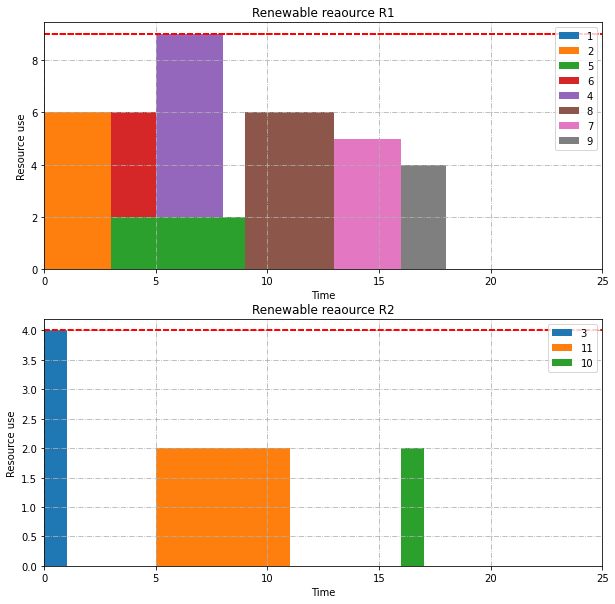

In [115]:
# feas1 (list) -----> feas2 (dict) as input of plottask()
feas33 = {1: [1],
        2: [3],
        3: [2],
        4: [5],
        5: [6],
        6: [4],
        7: [11],
        8: [8],
        9: [7],
        10: [10],
        11: [9]}
plottask(sk3,fk3,feas33)

In [95]:
feas2 = [1, 3, 2, 6, 4, 5, 11, 7, 10, 8, 9]
sk2,fk2,mp2 = modified_makespan(feas2,d_im,P_prec,num_r,R_r,U_imr)

iter:  1
Complete:  [1]
Activate:  []
SubE:  []


k:  0
i =  1
Rr_g: 
 [9. 4.]
i:  1 0.0
k:  1
i =  3
Rr_g: 
 [9. 4.]
i:  3 0.0
k:  2
i =  2
Rr_g: 
 [9. 0.]
i:  2 0.0
k:  3
i =  6
Rr_g: 
 [3. 0.]
ip:  2
iter:  2
Complete:  [1]
Activate:  [2, 3]
SubE:  []


k:  3
i =  6
Rr_g: 
 [3 0]
ip:  2
iter:  3
Complete:  [1, 3]
Activate:  [2]
SubE:  []


k:  3
i =  6
Rr_g: 
 [3 4]
ip:  2
iter:  4
Complete:  [1, 2, 3]
Activate:  []
SubE:  []


k:  3
i =  6
Rr_g: 
 [9. 4.]
i:  6 3.0
k:  4
i =  4
Rr_g: 
 [5. 4.]
false:  4
iter:  5
Complete:  [1, 2, 3, 6]
Activate:  []
SubE:  []


k:  4
i =  4
Rr_g: 
 [9. 4.]
i:  4 5.0
k:  5
i =  5
Rr_g: 
 [2. 4.]
i:  5 5.0
k:  6
i =  11
Rr_g: 
 [0. 4.]
i:  11 5.0
k:  7
i =  7
Rr_g: 
 [0. 2.]
ip:  5
iter:  6
Complete:  [1, 2, 3, 4, 6]
Activate:  [11, 5]
SubE:  []


k:  7
i =  7
Rr_g: 
 [7 2]
ip:  5
iter:  7
Complete:  [1, 2, 3, 4, 5, 6, 11]
Activate:  []
SubE:  []


k:  7
i =  7
Rr_g: 
 [9. 4.]
i:  7 11.0
k:  8
i =  10
Rr_g: 
 [4. 4.]
ip:  7
iter:  8
Complete:  [1, 2,

here:  1 0.0
1 0 0 0 0
3 0 0 4 1
2 0 0 6 3
6 3 0 4 2
4 5 0 7 3
here:  5 4.0
5 5 7.0 2 6
11 5 0 2 6
7 11 0 5 3
10 14 0 2 1
8 14 0 6 4
9 18 0 4 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


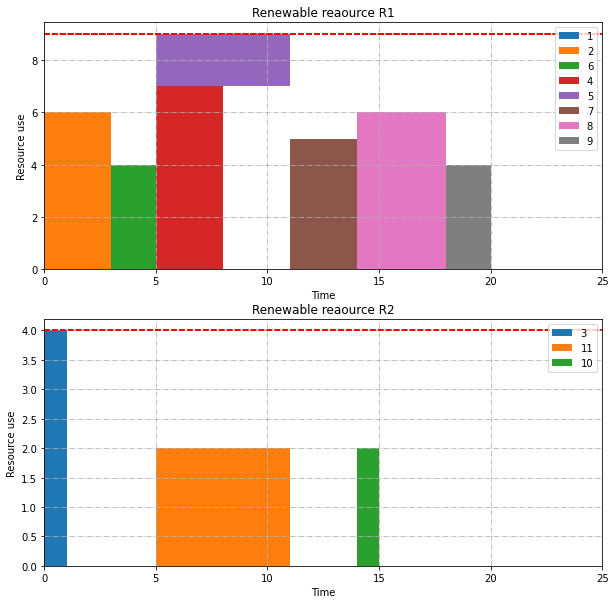

In [97]:
# feas1 (list) -----> feas2 (dict) as input of plottask()
feas22 = {1: [1],
        2: [3],
        3: [2],
        4: [6],
        5: [4],
        6: [5],
        7: [11],
        8: [7],
        9: [10],
        10: [8],
        11: [9]}
        
plottask(sk2,fk2,feas22)

In [69]:
feas1 = [1, 3, 2, 4, 6, 5, 7, 10, 11, 8, 9]
sk,fk,mp = modified_makespan(feas1,d_im,P_prec,num_r,R_r,U_imr)

iter:  1
Complete:  [1]
Activate:  []
SubE:  []


k:  0
i =  1
Rr_g: 
 [9. 4.]
i:  1 0.0
k:  1
i =  3
Rr_g: 
 [9. 4.]
i:  3 0.0
k:  2
i =  2
Rr_g: 
 [9. 0.]
i:  2 0.0
k:  3
i =  4
Rr_g: 
 [3. 0.]
false:  4
iter:  2
Complete:  [1]
Activate:  [2, 3]
SubE:  []


k:  3
i =  4
Rr_g: 
 [3 0]
false:  4
iter:  3
Complete:  [1, 3]
Activate:  [2]
SubE:  []


k:  3
i =  4
Rr_g: 
 [3 4]
false:  4
iter:  4
Complete:  [1, 2, 3]
Activate:  []
SubE:  []


k:  3
i =  4
Rr_g: 
 [9. 4.]
i:  4 3.0
k:  4
i =  6
Rr_g: 
 [2. 4.]
false:  6
iter:  5
Complete:  [1, 2, 3, 4]
Activate:  []
SubE:  []


k:  4
i =  6
Rr_g: 
 [9. 4.]
i:  6 6.0
k:  5
i =  5
Rr_g: 
 [5. 4.]
i:  5 6.0
k:  6
i =  7
Rr_g: 
 [3. 4.]
ip:  5
iter:  6
Complete:  [1, 2, 3, 4, 6]
Activate:  [5]
SubE:  []


k:  6
i =  7
Rr_g: 
 [7 4]
ip:  5
iter:  7
Complete:  [1, 2, 3, 4, 5, 6]
Activate:  []
SubE:  []


k:  6
i =  7
Rr_g: 
 [9. 4.]
i:  7 12.0
k:  7
i =  10
Rr_g: 
 [4. 4.]
ip:  7
iter:  8
Complete:  [1, 2, 3, 4, 5, 6, 7]
Activate:  []
SubE:  []


here:  1 0.0
1 0 0 0 0
3 0 0 4 1
2 0 0 6 3
4 3 0 7 3
6 6 0 4 2
here:  5 6.0
5 6 4.0 2 6
7 12 0 5 3
10 15 0 2 1
here:  11 10.0
11 15 2.0 2 6
8 15 0 6 4
9 19 0 4 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


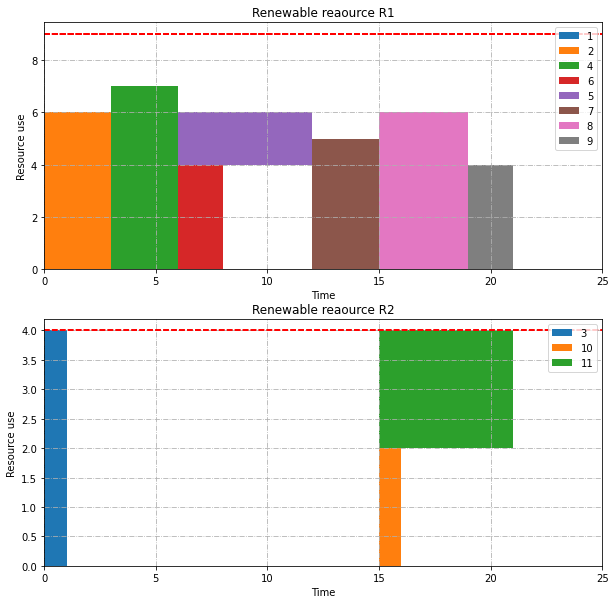

In [77]:
# feas1 (list) -----> feas2 (dict) as input of plottask()
feas11 = {1: [1],
        2: [3],
        3: [2],
        4: [4],
        5: [6],
        6: [5],
        7: [7],
        8: [10],
        9: [11],
        10: [8],
        11: [9]}
        
plottask(sk,fk,feas11)

# MVHSH for MRCPSPs
-----------------------
algorithm (a)+(b)+(c)

In [99]:
runMax=30
fBest=15

"""Main: whole procedures"""
def MVNSH(runMax,fBest):
    run = 0
    start = time.time()
    bestknown = []
    while run <= runMax:
        ss = time.time()
        print("Initializing...")
        s,f,order = initial_schedule2(d_im,P_prec,num_r,R_r,U_imr)
        makespan = max(f.flatten())
        if makespan == fBest:
            bestknown.append(makespan)
            break
        else:
            print("Shaking...")
            ord_list = [o[0] for o in list(order.values())]
            feas_uni = swap([ord_list])

            print("Local searching...")
            idx = random.randint(0,len(feas_uni)-1)
            feas_uni = feas_uni[idx]
            print(feas_uni)
            u_s,u_f,u_makespan = modified_makespan(feas_uni,d_im,P_prec,num_r,R_r,U_imr)

            if u_makespan == fBest:
                bestknown.append(u_makespan)
                break
            else:
                bestknown.append(min(makespan, u_makespan))
                run += 1
        ee = time.time()
        print("[run]: ", run)
        print("[time]: ", ee-ss)
        print("makespan = ", min(bestknown))

    end = time.time()
    tspan = end-start

    print("total run: ", run)
    print("makespan: ", min(bestknown))
    print("total time: ", tspan)

    return min(bestknown), tspan

# Plot Gantt Chart

In [71]:
def plottask(start,finish,order):
    """
    start (np.array)
    finish (np.array)
    order (dict)
    """
    numRow = len(num_r)
    numCol = 1

    s = start
    f = finish
    w = f-s
    h = np.zeros((len(num_r),len(A)))
    for i in range(len(A)):
        r_id,r = typeR(U_im[i+1])
        h[r_id][i] = r

    tag = np.zeros((numRow, tMax))
    rtag = np.zeros((numRow, tMax))
    yltag = np.zeros((len(num_r),len(A)))

    plt.figure(figsize=(10,10))
    for t,i in enumerate(order.values()):
        i = i[0]   # activity
        idx = i-1  # index
        r_id,r = typeR(U_im[i])
        si = int(s[r_id][idx])
        hi = int(h[r_id][idx])
        wi = int(w[r_id][idx])
        
        for t in range(si,si+wi):
            if tag[r_id][t] == 0:
                tag[r_id][t] = i
                rtag[r_id][t] = r

        if tag[r_id][si] != i:
            print("here: ", i, tag[r_id][si])

            yli = yltag[r_id][int(tag[r_id][si])-1]
            if hi <= yli:
                yl = 0
            else:
                yl = rtag[r_id][si]
        else: yl = 0
        yltag[r_id][idx]=yl
        print(i,si, yl, hi, wi)

        # if i != 1:
        # subplot(numRows, numCols, plotNum)
        plt.subplot(numRow,numCol,r_id+1)
        plt.axhline(y=R_r[r_id], ls="--", c="r")
        plt.bar(si, hi, wi, bottom=yl, align="edge", label="{}".format(i))
        plt.legend(loc="upper right")
        plt.xlabel('Time')
        plt.ylabel('Resource use')
        plt.xlim([0,tMax])
        plt.title('Renewable reaource R{}'.format(r_id+1))
        plt.grid(linestyle='-.')
    plt.savefig(path + 'Modified Schedules.png', format='png')